In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow --quiet

In [ ]:
!pip install keras-self-attention --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [ ]:
# Read in the Gold dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

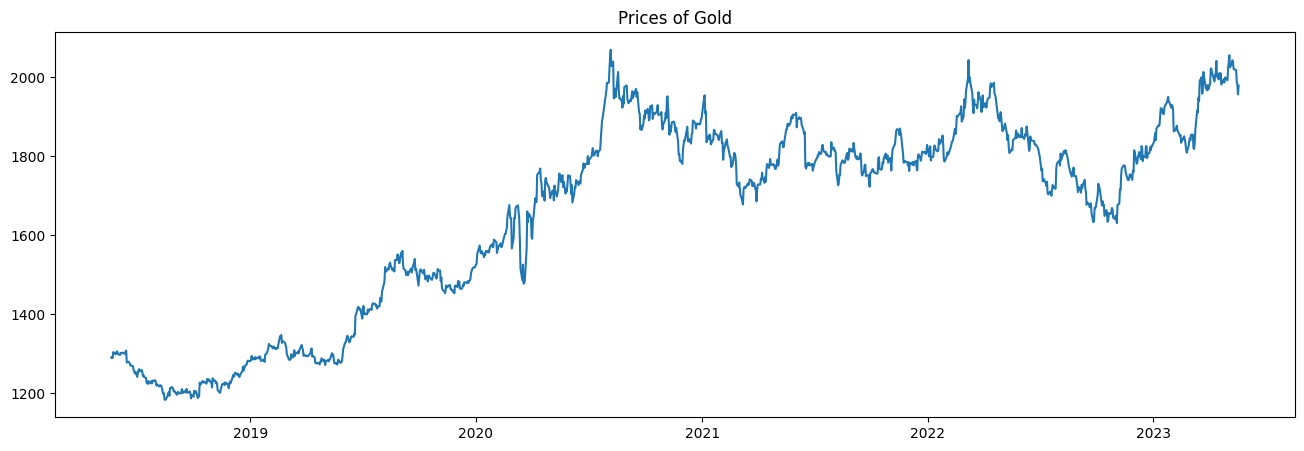

In [ ]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Price'])
plt.title('Prices of Gold')
plt.show()

# Split dataset (7-2-1)

---



In [ ]:
# Convert the 'df1' DataFrame to a NumPy array
data = df1.values

# Split the data (7-2-1)
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Create a MinMaxScaler object with a specified range
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
from keras.models import Model
from keras.layers import Dense, Input, SimpleRNN, Attention

input_seq = Input(shape=(5, 1))
rnn_output = SimpleRNN(50, return_sequences=True)(input_seq)
attention_output = Attention()([rnn_output, rnn_output])
reshaped_output = Reshape((-1,))(attention_output)
output = Dense(1)(reshaped_output)

model = Model(inputs=input_seq, outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')

save_model = 'save_model(7-2-1).hdf5'
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/80

Epoch 1: loss improved from inf to 2013311795200.00000, saving model to save_model(7-2-1).hdf5
19/19 - 1s - loss: 2013311795200.0000 - 1s/epoch - 77ms/step
Epoch 2/80

Epoch 2: loss improved from 2013311795200.00000 to 2013293314048.00000, saving model to save_model(7-2-1).hdf5
19/19 - 0s - loss: 2013293314048.0000 - 80ms/epoch - 4ms/step
Epoch 3/80

Epoch 3: loss improved from 2013293314048.00000 to 2013269458944.00000, saving model to save_model(7-2-1).hdf5
19/19 - 0s - loss: 2013269458944.0000 - 95ms/epoch - 5ms/step
Epoch 4/80

Epoch 4: loss improved from 2013269458944.00000 to 2013250584576.00000, saving model to save_model(7-2-1).hdf5
19/19 - 0s - loss: 2013250584576.0000 - 89ms/epoch - 5ms/step
Epoch 5/80

Epoch 5: loss improved from 2013250584576.00000 to 2013233545216.00000, saving model to save_model(7-2-1).hdf5
19/19 - 0s - loss: 2013233545216.0000 - 103ms/epoch - 5ms/step
Epoch 6/80

Epoch 6: loss improved from 2013233545216.00000 to 2013217423360.00000, saving 

In [ ]:
# model = Sequential()

# model.add(SimpleRNN(50, input_shape=(5, 1)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')

# model.compile(loss='mean_absolute_error', optimizer='adam')

# save_model = 'save_model(7-2-1).hdf5'

# best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

In [ ]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(7-2-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

29/29 [==============================] - 0s 2ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

9/9 [==============================] - 0s 3ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 3ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[400.2814636230469], [357.1955871582031], [318.1690673828125], [253.39599609375], [236.23890686035156], [241.122314453125], [247.24417114257812], [251.09617614746094], [251.0437774658203], [250.46824645996094], [250.126708984375], [250.03390502929688], [250.07835388183594], [250.11520385742188], [250.1278076171875], [250.1270751953125], [250.12342834472656], [250.121826171875], [250.12167358398438], [250.1219024658203], [250.12208557128906], [250.1221466064453], [250.1221160888672], [250.12208557128906], [250.12205505371094], [250.12205505371094], [250.12205505371094], [250.12205505371094], [250.12205505371094], [250.12205505371094]]


In [ ]:
# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

<Figure size 1600x500 with 0 Axes>

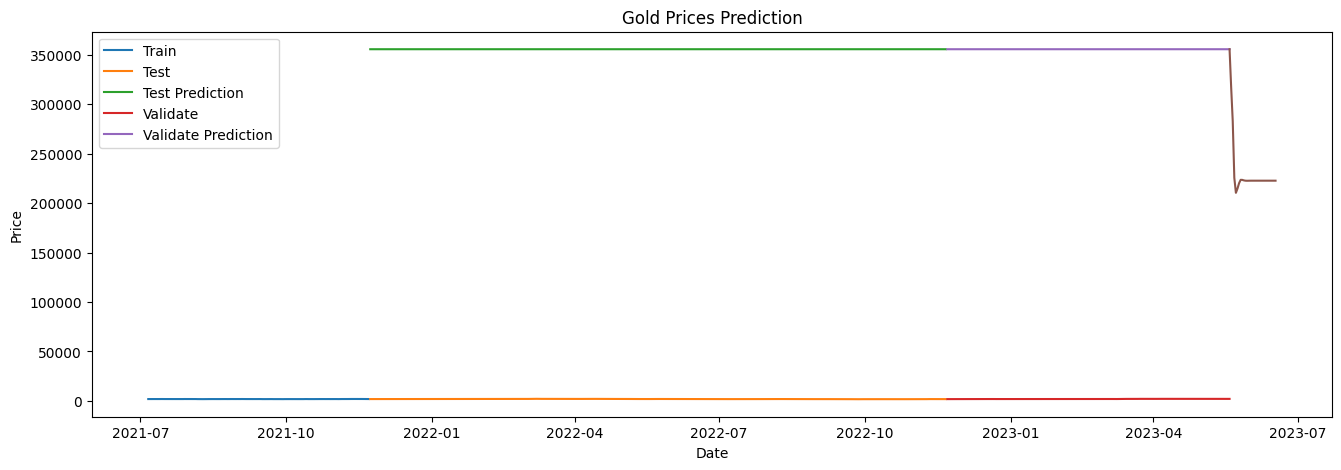

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
train_data

,Price
2018-05-21,1290.9
2018-05-22,1292.0
2018-05-23,1289.6
2018-05-24,1304.4
2018-05-25,1303.7
...,...
2021-11-16,1854.1
2021-11-17,1870.2
2021-11-18,1861.4
2021-11-19,1851.6


In [ ]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  13.138228934151783
MAPE:  0.7241334107287553
RMSE:  17.357372150135156

** Validate **
MAE:  14.822042330228372
MAPE:  0.7752277295043081
RMSE:  19.675014476984142


# Split dataset (6-3-1)

---



In [ ]:
# Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(6-3-1).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.40547, saving model to save_model(6-3-1).hdf5
16/16 - 1s - loss: 0.4055 - 780ms/epoch - 49ms/step
Epoch 2/80

Epoch 2: loss improved from 0.40547 to 0.09004, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0900 - 51ms/epoch - 3ms/step
Epoch 3/80

Epoch 3: loss improved from 0.09004 to 0.04202, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0420 - 43ms/epoch - 3ms/step
Epoch 4/80

Epoch 4: loss improved from 0.04202 to 0.03503, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0350 - 46ms/epoch - 3ms/step
Epoch 5/80

Epoch 5: loss improved from 0.03503 to 0.03014, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0301 - 46ms/epoch - 3ms/step
Epoch 6/80

Epoch 6: loss improved from 0.03014 to 0.02796, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0280 - 48ms/epoch - 3ms/step
Epoch 7/80

Epoch 7: loss improved from 0.02796 to 0.02661, saving model to save_model(6-3-1).hdf5
16/16 - 0

In [ ]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(6-3-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

25/25 [==============================] - 0s 1ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

13/13 [==============================] - 0s 1ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 2ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.8894456624984741], [0.8882157802581787], [0.8861180543899536], [0.8797885179519653], [0.8776371479034424], [0.8738488554954529], [0.8707354664802551], [0.8678763508796692], [0.864668071269989], [0.8617751598358154], [0.8588098883628845], [0.8559196591377258], [0.8531116247177124], [0.8503254055976868], [0.8476085066795349], [0.8449328541755676], [0.8423038125038147], [0.8397233486175537], [0.8371849656105042], [0.8346915245056152], [0.8322400450706482], [0.8298293948173523], [0.8274593353271484], [0.8251280784606934], [0.8228349685668945], [0.8205788731575012], [0.8183589577674866], [0.8161741495132446], [0.8140237927436829], [0.8119070529937744]]


<Figure size 1600x500 with 0 Axes>

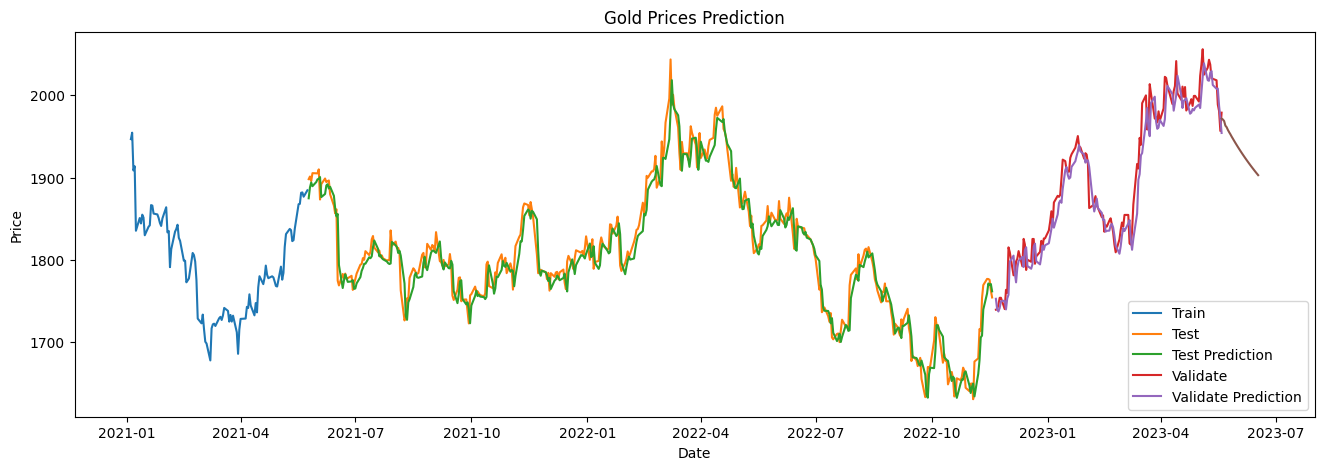

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  13.34265589763209
MAPE:  0.7368595664427334
RMSE:  17.960366388788657

** Validate **
MAE:  16.43398288406489
MAPE:  0.8597925233965551
RMSE:  21.05483871792114


# Split dataset (5-3-2)

---



In [ ]:
# Split data (5-3-2)
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(5-3-2).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.13074, saving model to save_model(5-3-2).hdf5
13/13 - 1s - loss: 0.1307 - 794ms/epoch - 61ms/step
Epoch 2/80

Epoch 2: loss improved from 0.13074 to 0.04279, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0428 - 45ms/epoch - 3ms/step
Epoch 3/80

Epoch 3: loss improved from 0.04279 to 0.02424, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0242 - 40ms/epoch - 3ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02424 to 0.02073, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0207 - 42ms/epoch - 3ms/step
Epoch 5/80

Epoch 5: loss improved from 0.02073 to 0.01936, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0194 - 47ms/epoch - 4ms/step
Epoch 6/80

Epoch 6: loss improved from 0.01936 to 0.01798, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0180 - 41ms/epoch - 3ms/step
Epoch 7/80

Epoch 7: loss improved from 0.01798 to 0.01719, saving model to save_model(5-3-2).hdf5
13/13 - 0

In [ ]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(5-3-2).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

21/21 [==============================] - 0s 1ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

13/13 [==============================] - 0s 2ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

9/9 [==============================] - 0s 2ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.9074913859367371], [0.9180024862289429], [0.9295570254325867], [0.9347640872001648], [0.942535400390625], [0.9496027827262878], [0.9566610455513], [0.9643199443817139], [0.9714694023132324], [0.9786579012870789], [0.985689640045166], [0.9925415515899658], [0.9993383884429932], [1.0059959888458252], [1.0125515460968018], [1.018997311592102], [1.0253193378448486], [1.031528353691101], [1.0376167297363281], [1.0435861349105835], [1.0494366884231567], [1.0551670789718628], [1.0607779026031494], [1.0662686824798584], [1.0716396570205688], [1.076891303062439], [1.0820236206054688], [1.087037444114685], [1.091933250427246], [1.0967119932174683]]


<Figure size 1600x500 with 0 Axes>

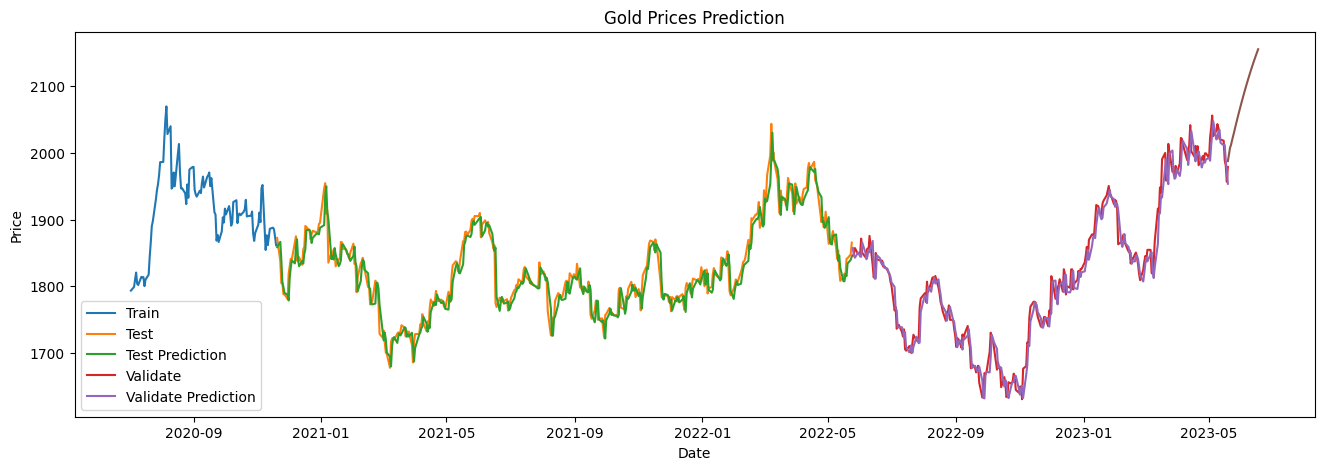

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  13.222201695393043
MAPE:  0.7219961107515434
RMSE:  17.917147076023923

** Validate **
MAE:  13.494728158804087
MAPE:  0.7370928419680646
RMSE:  18.119149307887394


# Evaluate Model

---